In [1]:
import numpy as np
from math import sqrt, log
from matplotlib import pyplot as plt
from numpy.random import default_rng
random = default_rng()
from tqdm import tqdm
import policy
from bandit import MultiTaskContextualBandit
from experiment import MultiTaskContextualBanditExperiment
import utils
import networkx as nx

## Parameters
We follow the simulated data generation of the algorithm's paper

## Bandit experiment
We generate a graph and we carry out repetitions for the bandit experiment.

In [7]:
repetitions = 10
n_users = 20
dim = 5
n_arms= 50

# Graph knowledge
Adj, Theta_0 = utils.graph_rbf(node_num= n_users, dimension= dim, clusters= 3, sparsity= 0.1)
L = utils.normalized_Laplacian(Adj)
Theta_0 = random.standard_normal((n_users, dim))
gamma= 0.5
Theta = np.linalg.solve(np.eye(n_users) + gamma*0.5*(L.T + L), Theta_0)


X =  random.standard_normal(size= (n_arms, dim))
#X /= np.linalg.norm(X, axis= 1, keepdims= True)
def context_sampler(dim, n_arms, random_generator):
    return X[random_generator.choice(range(len(X)), size= 50)]

noise_sampler = random.standard_normal
bandit = MultiTaskContextualBandit(Theta, n_arms= n_arms, context_sampler= context_sampler, 
                                        noise_sampler= noise_sampler, context_generator= 2)

/home/sdhouib/Documents/git_repos/bandits/utils.py:43: RuntimeWarning: divide by zero encountered in divide
  sqrtInvDeg = np.where(deg>0, 1/deg, 0)**0.5


## Laplacian Regularized Graph-Bandit
We implement the paper of Yang et al 2020, which is a multi-task bandit paper

In [8]:
rewards = []
rewards_oracle = []
errors = []
# player = GraphLinUCB_old(a= 1.0, delta= 0.01) 
player = policy.GraphLinUCB(a= 1.0, delta= 0.01, laplacian= L)
experiment = MultiTaskContextualBanditExperiment(horizon= 200)

for i in tqdm(range(repetitions)):
    experiment.run(bandit, player)
    rewards.append(experiment.reward_history)
    rewards_oracle.append(experiment.reward_history_oracle)
rewards = np.array(rewards).T
rewards_oracle = np.array(rewards_oracle).T

100%|██████████| 10/10 [00:00<00:00, 12.40it/s]


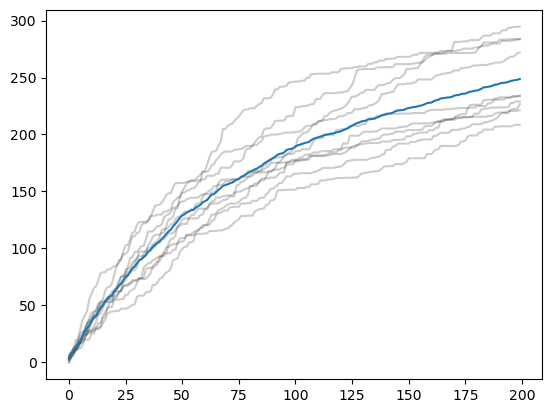

In [9]:
regret = np.cumsum(rewards_oracle - rewards, axis= 0)
plt.plot(regret, color= "k", alpha= 0.2);
plt.plot(regret.mean(axis= 1));

### Testing the quadratic form of the random walk laplacian

In [ ]:
from scipy.spatial.distance  import pdist, squareform


distMat = squareform(pdist(Theta, metric= "sqeuclidean"))


Adj = utils.generate_graph(n_users, p= 0.5)
deg = Adj.sum(axis = 1, keepdims= True)
invDeg = np.where(deg>0, 1/deg, 0.0)
Adj_norm= Adj*invDeg
Adj_norm_sym = 0.5*(Adj_norm + Adj_norm.T)

L = utils.random_walk_laplacian(Adj)
Lap = utils.Laplacian(Adj)
print(f"sums of normalized adjacency rows: {Adj_norm.sum(axis= 1)}")
print(np.trace(Theta.T @ L @ Theta) - 0.5*np.sum(distMat * Adj_norm_sym))

sums of normalized adjacency rows: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
3.273539037280139e-10
